# Week 10 Recitation

Interpolation and Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import ceil, floor
import scipy.stats as stats
import time

## Interpolation vs. Regression

We are starting kinetic analysis in the course now. This requires us to consider the "inverse problem," wherein we attempt to discern models and the parameters (rate constants, reaction orders, etc.) that describe the behavior of our systems. Generally, this comprises data fitting, model reconciliation, regression, and parameter estimation, which you theoretically know from prior courses in statistics and experimental methods.

We have many options for data fitting; a lot of them are built into Python, and we'll use them extensively.  These include tools like `np.polyfit()` and `opt.minimize()`.  In addition, there has been a lot of development around using artificial intelligence for parameter estimation (this is the gist of machine learning).  The core tools for this are all based on the fundamentals of data fitting and regression, so it is important that we consider them now before moving any further.  

In this Notebook, we're going to do a deep dive into what's behind ***linear regression***. The topics discussed today are what happens when you use a trendline in Excel or `np.polyfit()` in Python.  These concepts also form the basis of more advanced modelling-and-prediction algorithms used in Machine Learning and Artificial Intelligence. If you can understand how to build interpolating polynomials and regression polynomials (and the difference between them) using linear algebra, this is a fundamental skill in data analytics, and it may prove useful to you depending on the direction that your career takes.  Next, we will cover some fundamental ideas underlying interpolation and regression.  Both of these involve developing a model that describes observed data, but they have some key differences.

When we develop an **interpolating function**, we build a model that *passes exactly through all of the data points that we have available*. Typically, we use these to infer un-measured values that are between the limits of values that we have measured.  Think about linear interpolation to find a value between two points on a steam table as an example.  Or, if you like, think about how we've used interpolating polynomials in this course to find, say, the Volume required to achieve a specific fractional conversion after integrating a PFR model with numerical methods.

When we perform a **regression**, we are building a model that *minimizes the error between it and the measurements we've made*.  It will not pass through all data points; in fact, it may not pass through any of our measured data points. Regressed models are what we use when we have overdetermined systems, but they still provide predictive power in that they will let us predict the state of our system for a given set of inputs.

We'll cover interpolation first because it is essentially just solving linear systems of equations. Once you understand how to construct interpolating polynomials, then linear regression is a straightforward extension of that. 

## The Utility of Functions

It's worth refreshing our understanding of functions.  Basically, a function is something that maps the value of an input (e.g., x) to the value of an output (e.g., y).  We can generalize this concept to any sort of process we want to model, which is what makes the basic concept of a function so useful:  if you have a function that accurately describes your system, then you can predict the metric of interest (here, "y") for any value of input that your process takes (here, "x").

You can think of this in terms of all kinds of processes. As a chemical engineer, I might be interested in how much benzene my reactor products as a function of temperature. With that function in hand, I can easily model how changing temperature will impact my benzene production. But this really can be any sort of model that captures either a fundamental dependence (change in rate constant with temperature) or a corrleation (let's just say that the price of bitcoin varys as a function of rainfall in Myanmar because that's as good a predictor of BTC price as anything else). Once you know how BTC price changes with fluctuations in Burmese precipitation, then you can predict the BTC price by monitoring something physically tangible (rainfall in Myanmar).

You get the idea:  we use functions to build *models* that describe a process of interest.

### Univariate Functions

For now, we restrict consideration to univariate functions, which means a function that has only one input variable.  I will use $y = f(x)$ for all examples.  Univariate:  I only need the value of $x$ to predict the value of $y$.

We talk a lot about polynomials, which are functions of variable order, where order is the value of the highest exponent on "x" in your model.  For example:

#### Zero order

$$y(x) = 5x^0$$

That's zero order because the exponent on x is 0, and $x^0 = 1$.  In practice, we'd never write $x^0$ since we know it is just equal to 1, but it's good to illustrate it here just to make a point that the above is a zero-order polynomial in x.  Typically, you'd just write a zero order polynomial as

$$y(x) = 5$$

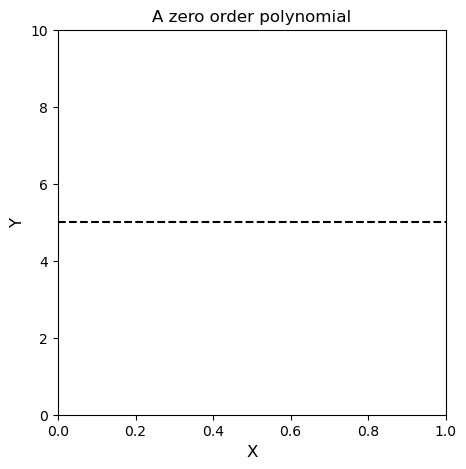

In [2]:
x0 = np.linspace(0,1,10)
y0 = np.zeros(len(x0)) + 5.0

plt.figure(figsize = (5, 5))
plt.plot(x0, y0, color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(min(x0), max(x0))
plt.title('A zero order polynomial')
plt.show()

#### First order

$$y(x) = 10x^1 + 5x^0 = 10x +5$$

You can see that the highest exponent on x here is a 1, so it is a first order polynomial.  When something has a highest order 1, we call that a linear model because, when you graph it, it is a straight line.  This one is familiar to pretty much everyone.  The constant term "5" is called the y-intercept, and the coefficient of $x^1$ (10) is called the slope.

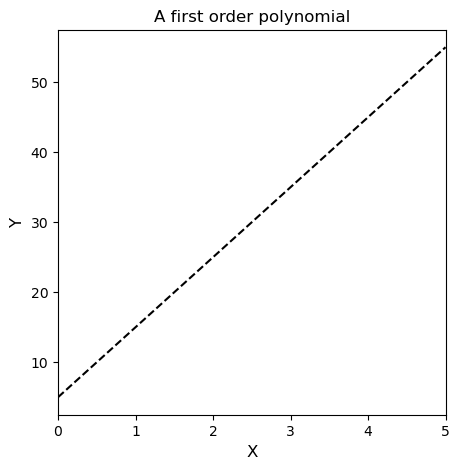

In [3]:
x1 = np.linspace(0, 5, 10)
y1 = lambda x: 10*x + 5

plt.figure(figsize = (5, 5))
plt.plot(x1, y1(x1), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(min(x1), max(x1))
plt.title('A first order polynomial')
plt.show()

**Second order:**

$$y(x) = 0.5x^2 + 10x^1 + 5x^0 = 0.5x^2 + 10x + 5$$

Here, we have a second order (quadratic) since the leading term has an exponent of 2 on $x$.  You can see what it looks like below.

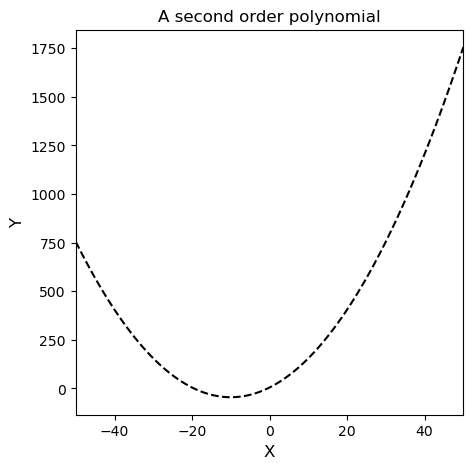

In [4]:
x2 = np.linspace(-50, 50, 100)
y2 = lambda x: 0.5*x**2 + 10*x + 5

plt.figure(figsize = (5, 5))
plt.plot(x2, y2(x2), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(min(x2), max(x2))
plt.title('A second order polynomial')
plt.show()

And so on, we can imagine 3rd, 4th, or a general "nth" order polynomial:

**Third order:**

$$y(x) = -0.75x^3 + 0.5x^2 + 10x + 5$$

**Fourth order:**

$$y(x) = 0.035x^4 - 0.75x^3 + 0.5x^2 + 10x + 5$$

**nth order:**

$$y(x) = \alpha_{n}x^{n} + \alpha_{n-1}x^{n-1} \ ... \ + \ 0.035x^4 - 0.75x^3 + 0.5x^2 + 10x + 5$$

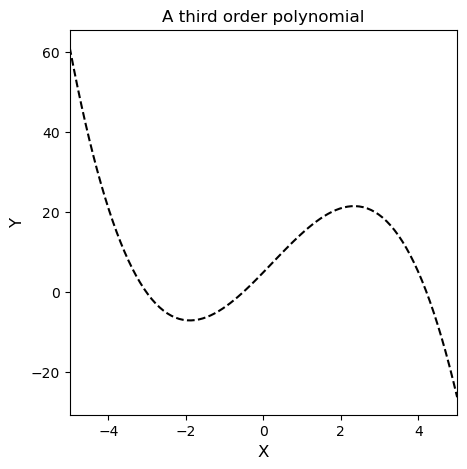

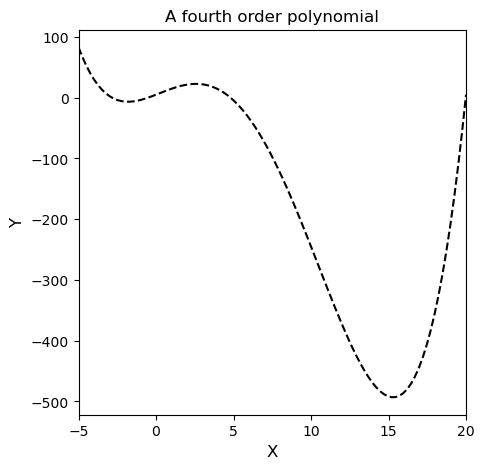

In [5]:
x3 = np.linspace(-5, 5, 100)
y3 = lambda x: -0.75*x**3 + 0.5*x**2 + 10*x + 5 

plt.figure(figsize = (5, 5))
plt.plot(x3, y3(x3), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(min(x3), max(x3))
plt.title('A third order polynomial')
plt.show()

x4 = np.linspace(-5, 20, 100)
y4 = lambda x: 0.035*x**4 - 0.75*x**3 + 0.5*x**2 + 10*x + 5 

plt.figure(figsize = (5, 5))
plt.plot(x4, y4(x4), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(min(x4), max(x4))
plt.title('A fourth order polynomial')
plt.show()

## Data Modelling: An Inverse Problem

Most of us that analyze data are in the inverse position.  Usually we have measured values of our output (e.g., y or the price of BTC) at various values of our input (e.g., x or rainfall in Myanmar). We would like to have a function (model) that tells us explicitly how our output (BTC price) changes as a function of our input (Burmese rainfall), but we don't know that function - we have to build the model by analyzing the data.  That is the core of the inverse problem.

We should briefly consider the difference between interpolation and extrapolation.  ***Interpolation*** would be inferring the value of an output for a value of input that lies *between* measurements you have already made, whereas ***extrapolation*** would be forecasting the value of an output at a value of input that lies *outside* of the range that you've measured.  In general, interpolation is safer than extrapolation, but you can see why the ability to extrapolate to input values that you haven't measured would be useful: 

"Wow, it has never rained 145 inches in Burma in a day before!  I wonder what this will do to the price of BTC?"

Loosely, we'll look at two possible approaches to developing a model from data.  The first is to construct an "interpolating polynomial," which we'll define loosely as a function that passes through each data point of interest exactly.  The second is a "regression polynomial," which is a function that models the line of best fit through all data of interest.  By "best fit," we mean the model that gives the least possible error between measurement and prediction.

Regardless of the approach, I've found it most intuitive to start by framing this problem using systems of equations, which form a good foundation for the more complicated topics in model fitting and parameter estimation.

### Converting data into a system of equations

The basic idea here is that you have available to you, either through your own measurement or through mining some sort of database, a value of an output (anything you're interested in, e.g., price of BTC) measured at one or more values of an input (anything that you suspect will influence the value of your output, e.g., rainfall in Myanmar). 

For now, we'll keep it simple:  we have an output of interest called "y" and an input of interest called "x".  In familiar terms, these would be the dependent variable (y) and independent variable (x). So, the minimum size set of data we will look at here is 2 measurements.  If you have one measurement (say y = 5 when x = 7), the only prediction you can make from it is that y = 5 when x = 7. Once you get to two measurements, you can start to build models, for reasons that I think become more clear when you look at how this is done.

So here, we have two (x,y) measurements. Specifically, when x = 1, y = 4...and when x = 2, y = 7.  More concisely, these are (x,y) pairs: (1,4) and (2,7).

Let's put those on a graph:

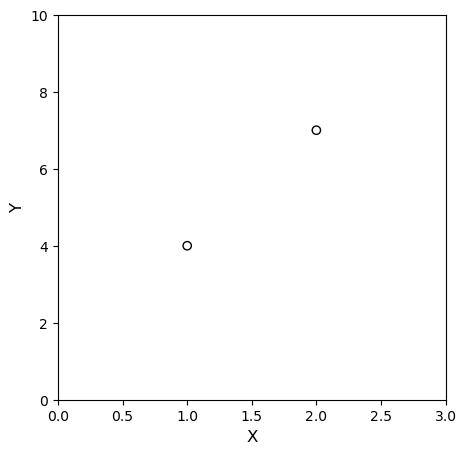

In [6]:
x = [1, 2]
y = [4, 7]

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,3)
plt.show()

Looking at the data now, you can intuit something fundamental about data fitting.  It is very clear that if you want to put a straight line (linear) through those points, there is exactly one line that will pass through both points.  If, on the other hand, you want to put a curved line through them...well...there could be an infinite number of quadratics, cubics, etc. that will pass exactly through both points.

There is a really nice mathematical reason for this: if we use this data to construct a system of equations, it is fully determined, and it has a unique solution. Specifically, let's combine our measured values with our knowledge of a linear function, namely that the general equation for a line expressed with an unknown slope (m) and an unknown y-intercept (b) is given by 

$$y(x) = mx^1+bx^0 = mx + b$$

With that equation in mind, realize that we have two (x,y) pairs from which to construct a system of equations.  Substituting those values, we get the following two equations:

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

Ah!  A system of equations!  This looks like an algebra problem!! The nature of the inverse problem reveals itself here -- you know the values of the independent variables (x) and dependent variables (y), but ***you do not know the coefficients in the polynomial that describe the line***.  So, the core of your inverse problem is to find those coefficients.  Fortunately, here, you have 2 equations, written in 2 unknowns (m and b).  It's fully determined, and there is one and only one solution:

\begin{align}
    m = 3\\
    b = 1\\
\end{align}

If we overlay our data on that line, we'll find that it passes through both points exactly.

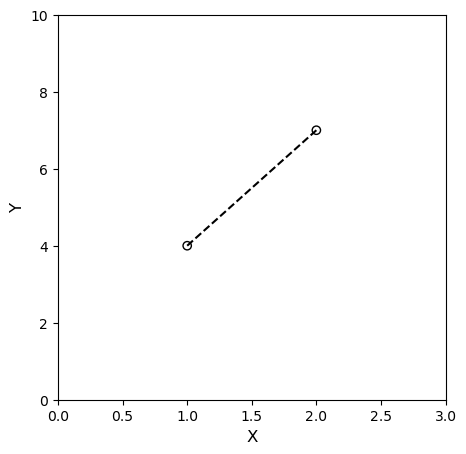

In [7]:
x = np.array([1, 2])
y = np.array([4, 7])
m = 3
b = 1
xline = np.array([1, 2])
yline = lambda x: m*x + b

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,3)
plt.show()

This is the basic concept of an "interpolating polynomial."  We have constructed a function that passes through each point exactly, and you'll notice again that if we do this for two points, then there is one and only one line that passes exactly through the pair.

If instead I tried to fit a zero order polynomial to my data (i.e, $y = C$, where C is a constant):

\begin{align}
    4 = C\\
    7 = C\\
\end{align}

You see that this is impossible - there is no constant, at least in normal mathematics, that simultaneously equals 4 and 7. That is to say, you need at least a first order polynomial to be able to pass through both data points.

In contrast, if I were to try to fit a second order polynomial here, where the general expression for a 2nd order polynomial is:

$$y(x) = \alpha_2x^2 + \alpha_1x^1 + \alpha_0x^0 = \alpha_2x^2 + \alpha_1x + \alpha_0$$

You would find that you generate the following system of equations by substituting in the (x,y) pairs we measured:

\begin{align}
    4 = 1\alpha_2 + 1\alpha_1 + \alpha_0\\
    7 = 4\alpha_2 + 2\alpha_1 +  \alpha_0\\
\end{align}

No good -- there are 2 equations written in 3 unknowns ($\alpha_0$, $\alpha_1$, and $\alpha_2$).  This system is underdetermined (not enough constraints), and we can find an infinite number of ($\alpha_0$, $\alpha_1$, $\alpha_2$) sets that will create 2nd order polynomials that pass exactly through each point.

So the corollary to the above statement about a 0 order polynomial is that there are (I think) an infinite number of 2nd order polynomials that will describe this data because it is an underdetermined system.

In data fitting, these ideas generalize to larger and larger data sets.  The general concept is that, when given $n+1$ data points, you can fit an $n_{th}$ order polynomial that passes exactly through those $n+1$ data points.  If your polynomial is lower order than $n$, the system is overdetermined (too many constraints), and you can't find a unique solution.  If your polynomial is higher order than $n$, the system is underdetermined (too few constraints), and you can't find a unique solution.  

### A Quadratic Example

For a concrete illustration of that concept--that you can find a unique, $n^{th}$ order polynomial to pass exactly through $n+1$ data points, let's consider the scenario where you make 3 (x,y) measurements:  (1,8), (2,4), and (3,6).  That's 3 data points, so we can find a unique, 2nd order (quadratic) polynomial that goes through each data point.

First, it's always helpful to plot the data:

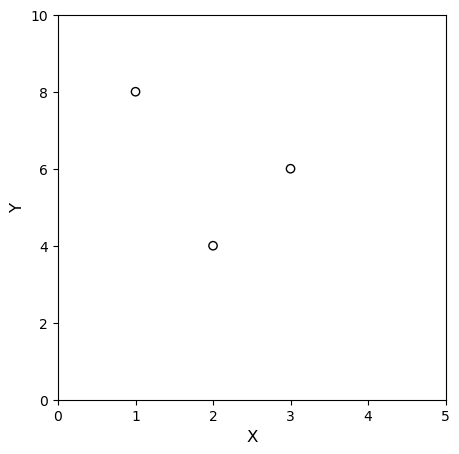

In [8]:
x = [1, 2, 3]
y = [8, 4, 6]

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,5)
plt.show()

Now you can see that you need some curvature to pass through those 3 data points--a straight line won't do it.  Start in the same place:  use the data to make a system of equations using the generic model for a 2nd order polynomial, i.e., $y(x) = \alpha_2x^2 + \alpha_1x^1 + \alpha_0x^0$.  Substituting (x,y) pairs into this model gives:

\begin{align}
    8 = 1\alpha_2 + 1\alpha_1 + \alpha_0\\
    4 = 4\alpha_2 + 2\alpha_1 + \alpha_0\\
    6 = 9\alpha_2 + 3\alpha_1 + \alpha_0\\
\end{align}

And there you see why you get to find a unique 2nd order polynomial.  The system of equations is fully determined--there are 3 equations, and 3 unknowns ($\alpha_0$, $\alpha_1$, $\alpha_2$), so there is a unique set of ($\alpha_0$, $\alpha_1$, $\alpha_2$) values that define this data set.

You find them by algebraic solution of the system to get:

\begin{align}
    \alpha_2 &= 3\\
    \alpha_1 &= -13\\
    \alpha_0 &= 18\\
\end{align}

And below, we'll overlay that polynomial with our original data set.  You'll see that the line passes exactly through each data point.

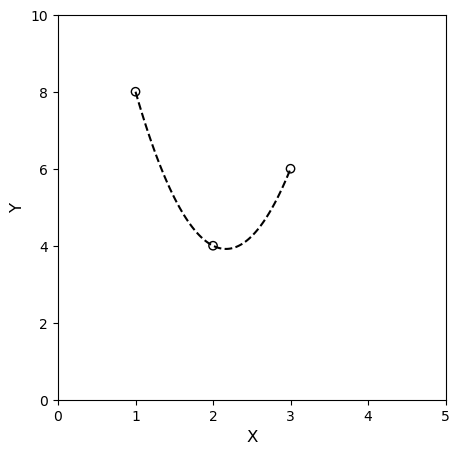

In [9]:
xline = np.linspace(1, 3, 100)
alpha2 = 3
alpha1 = -13
alpha0 = 18
yline = lambda x: alpha2*x**2 + alpha1*x + alpha0

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,5)
plt.show()

Again, reinforcing those general concepts, I can't find a straight line that will pass through all three ($n+1$) data points...and I can find infinite cubics (third order polynomials) that will pass through all data.  Only the quadratic ($n^{th}$ order)is "just right" because the system is fully determined.

These are super useful concepts, and the easiest way to generalize them to higher order systems (and minimize the tedium in solving algebraic equations on your part) is to take advantage of linear algebra.

## A Matrix/Vector representation of the Inverse Problem

Going back to our linear problem, where we had two (x,y) pairs, (1,4) and (2,7), that we wanted to describe with a linear model $y(x) = mx+b$. In doing so, we wrote the following two equations.

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

To support abstraction to higher order polynomials, I'm going to replace the coefficients in that linear polynomial (m and b) with $\alpha_i$ values.  The $\alpha$ is just a constant-valued coefficient, and the subscript $i$ represents the degree of x that particular $\alpha$ is multiplied by in the polynomial.  

\begin{align}
    4 = 1\alpha_1 + \alpha_0\\
    7 = 2\alpha_1 + \alpha_0\\
\end{align}

I'm also going to put it in the form that I typically see with this type of problem.  This is just a rearrangement.

\begin{align}
    1\alpha_1 + 1\alpha_0 = 4\\
    2\alpha_1 + 1\alpha_0 = 7\\
\end{align}

Now I see this is just a system of equations that are all linear with respect to the coefficients, i.e., all of the $\alpha$'s have an exponent of 1.  Realizing that, I can re-write this in Matrix/Vector notation:

$$\begin{bmatrix} 1 & 1 \\ 2 & 1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} 4 \\ 7 \end{bmatrix}$$

Just a refresher:  this is matrix multiplication.  In matrix multiplication, you multiply each element in a row by each element in the column and sum their values.

Breaking down these terms, you see that the matrix on the left corresponds to the value of x that is multiplied by each value of $\alpha$.  Note that $\alpha_0$ multiplies by $x^0$, but we usually just call that 1 since we know its value already.  In the first row, we have values of $x_1$, which is the x in our first (x,y) pair (1,4).  In the second row, we have values of $x_2$, which is the x in our second (x,y) pair (2,7). If we multiply these x values by the coefficients as shown above, it gives us the values of $y_1$ in the first row and $y_2$ in the second row.

$$\begin{bmatrix} x_1^1 & x_1^0 \\ x_2^1 & x_2^0 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

Usually, you'll see this matrix equation in the shorthand:

$$XA = Y$$

Where X is a matrix of input values, A is a vector of coefficients that specify the polynomial you're trying to fit, and Y is a vector of your measured output values at each corresponding value of your input (X).  Since we have measured values of X and Y, then A contains all of the unknowns (coefficients) in this system.

This is where we leverage linear algebra to do the heavy lifting of solving for an interpolating polynomial.  If this were a standard algebraic equation, we'd solve for A as:

$$A = Y/X$$

or, more relevant here:

$$A = X^{-1}Y$$

Matrices behave a little differently.  Instead of the first, more intuitive division operator, we want to take a Matrix Inverse here.  I like to visualize this as multiplying both sides of our equation by the inverse of the X matrix in steps.  So with a linear algebra solution, I'd solve this problem with the following steps:

\begin{align}
    XA &= Y\\
    X^{-1}XA &= X^{-1}Y\\
    IA &= X^{-1}Y\\
    A &= X^{-1}Y\\
\end{align}

This is the Matrix equivalent of dividing through by X.  If you're unfamiliar with $I$, this is the identity matrix, which is the Matrix equivalent of the number 1.  When I multiply $I$ by a matrix or Vector, it returns the value of that Matrix or Vector unchanged, so I drop the $I$ in the final line.  Formally:

$$IA = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
A$$

So, we'll put this into practice in the cell below, where I'll create an X matrix and a Y vector, and then solve for A using a matrix inversion.  You see we get the exact same values of $\alpha_0$ (intercept) and $\alpha_1$ (slope) that we got above.  It's just a much more succinct solution.  Note that instead of using full matrix inversion as noted above, it is generally more efficient to use routines built into the programming language for solving linear systems of equations (they are more efficient than a full matrix inversion):

Matlab and Julia use a "left divide operator," for example.

$$A = X \ \backslash \ Y$$

In Python, we use a numpy feature.  This one is `np.linalg.solve(X, Y)`

In [10]:
X = np.array([[1, 1], [2, 1]])
Y = np.array([4, 7])
print(X, '\n')
print(Y, '\n')
A = np.linalg.solve(X, Y)
slope = A[0]
y_intercept = A[1]
print(A)

[[1 1]
 [2 1]] 

[4 7] 

[3. 1.]


### Matrix interpretation of the 2nd order problem

This really becomes much more useful when we got to higher order polynomials, where the algebra becomes more cumbersome.  So let's apply to our second order example.  Recall, we're trying to fit a quadratic ($n_{th}$ order) to 3 data points ($n+1$ data points): (1,8), (2,4), and (3,6)

Above, we used that to generate this system of equations:

\begin{align}
    8 = \alpha_0 + 1\alpha_1 + 1\alpha_2\\
    4 = \alpha_0 + 2\alpha_1 + 4\alpha_2\\
    6 = \alpha_0 + 3\alpha_1 + 9\alpha_2\\
\end{align}

Which we can then put into the matrix form we developed in the previous cell:

\begin{align}
    1\alpha_2 + 1\alpha_1 + 1\alpha_0 = 8\\
    4\alpha_2 + 2\alpha_1 + 1\alpha_0 = 4\\
    9\alpha_2 + 3\alpha_1 + 1\alpha_0 = 6\\
\end{align}

And then:

$$\begin{bmatrix} 1 & 1 & 1 \\ 4 & 2 & 1 \\ 9 & 3 & 1 \end{bmatrix} \times 
\begin{bmatrix} \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} 8 \\ 4 \\ 6 \\ \end{bmatrix}$$

Which is just numbers plugged into the general form:

$$\begin{bmatrix} x_1^2 & x_1^1 & x_1^0 \\ x_2^2 & x_2^1 & x_2^0 \\ x_3^2 & x_3^1 & x_3^0 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \end{bmatrix}$$

And so, we again arrive at:

$$XA = Y$$

Which we can solve by matrix inversion for all unknown coefficients, which we recall should be (-18, 13, 3)

The key to this idea is that, although our models are nonlinear in X, all of our X values are known.  We are solving for coefficients, and the equations above are always linear in the coefficients, so we can use matrix methods.

In [11]:
X = np.array([[1, 1, 1], [4, 2, 1], [9, 3, 1]])
Y = np.array([8, 4, 6])
print(X, '\n')
print(Y, '\n')
A = np.linalg.solve(X,Y)
print(A)

[[1 1 1]
 [4 2 1]
 [9 3 1]] 

[8 4 6] 

[  3. -13.  18.]


This is awesome because it is a **completely** general concept.  You can construct any model to match your data points in this way, and you can use the matrix inversion to solve for the uknown coefficients.  I can do this for any $n_{th}$ order polynomial I wish:

$$\begin{bmatrix} x_1^{n} & x_1^{n-1} & \cdots & x_1^3 & x_1^2 &  x_1^1 & x_1^0 \\ x_2^{n} & x_2^{n-1} & \cdots & x_2^3 & x_2^2 &  x_2^1 & x_2^0 \\ x_3^{n} & x_3^{n-1} & \cdots & x_3^3 & x_3^2 &  x_3^1 & x_3^0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_{n}^{n} & x_{n}^{n-1} & \cdots & x_{n}^3 & x_{n}^2 &  x_{n}^1 & x_{n}^0 \\ x_{n+1}^{n} & x_{n+1}^{n-1} & \cdots & x_{n+1}^3 & x_{n+1}^2 &  x_{n+1}^1 & x_{n+1}^0 \end{bmatrix} \times 
\begin{bmatrix} \alpha_n \\ \alpha_{n-1} \\ \vdots \\ \alpha_3 \\ \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_{n} \\ y_{n+1} \end{bmatrix}$$

It looks complicated, but realize that it is an expression for a generic, $n^{th}$ order polynomial fit to $n+1$ (x,y) pairs.

And again: no matter how nonlinear my model is in ***X***, we are solving the inverse problem of trying to find coefficients from known values of X and Y.  The problem is ***always linear in the coefficients, so we can use matrix methods***.

The most tedious part of these problems is generating the X matrix from your input values. It is not too bad if you have good support for vectorized operations in your programming language.  For example, let's say we want to fit a 10th order polynomial to 11 (x,y) pairs that I'm going to generate randomly.  I'll just walk through the way you'd construct the X matrix and Y vector from this data.  Once you do that, it's just a matrix inversion as usual.

In [12]:
rng   = np.random.default_rng(12345)
xdata = rng.random(11)
ydata = rng.random(11)
print(xdata, '\n')
print(ydata, '\n')

[0.22733602 0.31675834 0.79736546 0.67625467 0.39110955 0.33281393
 0.59830875 0.18673419 0.67275604 0.94180287 0.24824571] 

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 



Now we'll go ahead and plot this mess:

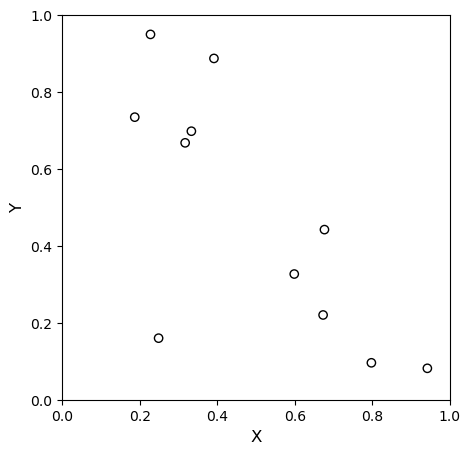

In [13]:
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

I can find one unique 10th order polynomial to fit my 11 data points exactly, so let's create that X matrix to represent this.

In [14]:
X1 = np.ones((11,11))
X1[:,0]  = xdata**10
X1[:,1]  = xdata**9
X1[:,2]  = xdata**8
X1[:,3]  = xdata**7
X1[:,4]  = xdata**6
X1[:,5]  = xdata**5
X1[:,6]  = xdata**4
X1[:,7]  = xdata**3
X1[:,8]  = xdata**2
X1[:,9]  = xdata

# power = 1
# print(np.round(np.reshape(xdata**power, (len(xdata),1)), 2), '\n')
# print(np.round(X1, 2))

The corresponding Y vector is easy:

In [15]:
Y1 = ydata
print(Y1)

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ]


Now, solve for A using `np.linalg.solve()`; this will give us the 11 coefficients needed to describe a 10th order polynomial

In [16]:
A = np.linalg.solve(X1, Y1)
print(A)

[-1.90239510e+07  1.01073201e+08 -2.35197349e+08  3.15169115e+08
 -2.68926703e+08  1.52477761e+08 -5.81160612e+07  1.46917321e+07
 -2.35630364e+06  2.16419264e+05 -8.64128002e+03]


Now, let's use those coefficients to create a polynomial of 10th order that can accept vector arguments.  I'll pass a 100 element set of x values to create a smooth line between x = 0 and x = 1.  You'll see it hits all of our data points exactly.  No comment yet as to what it does between those points.

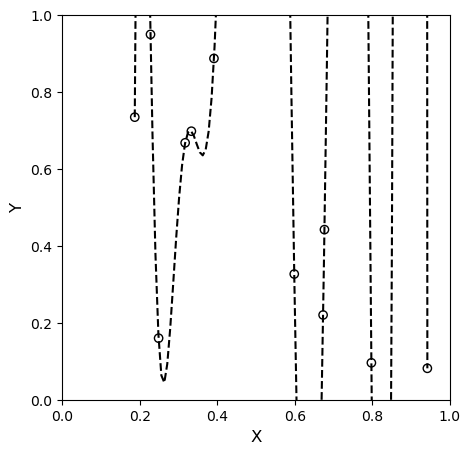

In [17]:
yline = lambda x: A[0]*x**10 + A[1]*x**9 + A[2]*x**8 + A[3]*x**7 + A[4]*x**6 + A[5]*x**5 + A[6]*x**4 + A[7]*x**3 + A[8]*x**2 + A[9]*x + A[10]
xline = np.linspace(min(xdata), max(xdata), 100)

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Now, let's plot this on a larger y axis...remember this interpolating function is **supposed to** describe precisely what happens between all of our measured points.

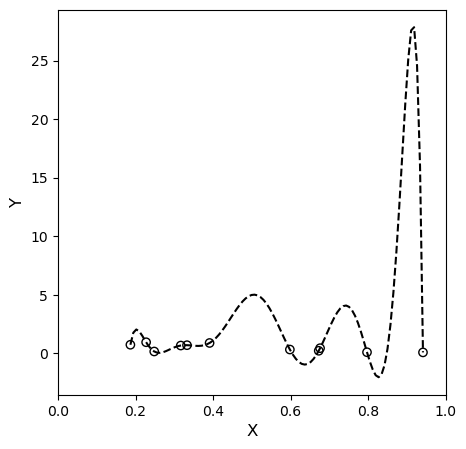

In [18]:
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.xlim(0,1)
plt.show()

That doesn't inspire confidence.  There is no reason to believe the data should behave that way in between the measured points, especially since all of our measured y values were between 0 and 1.  Why would I all of a suddent have a value of y $\approx$ 5 at x $\approx$ 0.5, or a value of y $\approx$ 30 at x $\approx$ 0.9.  This is a red flag in data fitting...

What has happened here is that we've over-fit the system, and we are capturing all of the "wiggles" in the data with a mathematically rigorous equation.  But we've gone to such a high order polynomial that it is very likely to go far outside of the measurement range at any point not directly measured by us (and thus captured exactly by the interpolating polynomial).

Another danger associated with high order polynomials--they have limited predictive power outside of the range where we fit them.  All polynomials go to $\pm \infty$ as the function arguments go to $\pm \infty$.  This actually happens really quickly for high order polynomials (see below for what happens when we try to use the model to predict what happens to y on the domain x = (-2, 3).

The take home: we should be careful not to overfit the data.  Just because we have 11 data points, it isn't necessarily a good idea to fit a maximum order polynomial to them.  Also, we have to remember that these polynomials only describe what happens inside the limits where we have collected data.  Extrapolation beyond ranges where we've collected data is risky, and it is especially risky when we use complex, highly nonlinear models to describe the data.

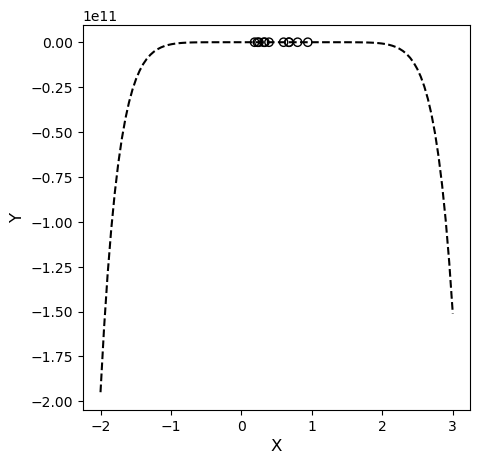

In [19]:
xline = np.linspace(-2, 3, 100)
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

## Some General Notes

The "X" matrix we used above is something that is used so frequently in data fitting that it is a well known concept.  It is called the Vandermonde matrix, and, of course, Python will automatically generate one from our data for us.  This is built into numpy as `np.vander()`

In [20]:
X2 = np.vander(xdata)
print(np.round(X2, 2), '\n')
print(np.round(X1, 2), '\n')
print(X2.shape)

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.23 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.03 0.1  0.32 1.  ]
 [0.1  0.13 0.16 0.2  0.26 0.32 0.4  0.51 0.64 0.8  1.  ]
 [0.02 0.03 0.04 0.06 0.1  0.14 0.21 0.31 0.46 0.68 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.02 0.06 0.15 0.39 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.11 0.33 1.  ]
 [0.01 0.01 0.02 0.03 0.05 0.08 0.13 0.21 0.36 0.6  1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.03 0.19 1.  ]
 [0.02 0.03 0.04 0.06 0.09 0.14 0.2  0.3  0.45 0.67 1.  ]
 [0.55 0.58 0.62 0.66 0.7  0.74 0.79 0.84 0.89 0.94 1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.06 0.25 1.  ]] 

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.23 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.03 0.1  0.32 1.  ]
 [0.1  0.13 0.16 0.2  0.26 0.32 0.4  0.51 0.64 0.8  1.  ]
 [0.02 0.03 0.04 0.06 0.1  0.14 0.21 0.31 0.46 0.68 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.02 0.06 0.15 0.39 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.11 0.33 1.  ]
 [0.01 0.01

## Regression

In these cases where we have a lot of data, particularly noisy (messy) data like we usually see from an experiment, we don't really want to "overfit" the data by using a polynomial of maximum order.  Instead, we *generally* will want to find a lower order polynomial that provides a line of best fit to the data.  This is the basic idea behind regression -- it is a method of analysis wherein we seek to minimize the error between our model predictions and the measurements (data) that we have available.  How do we decide on the polynomial or functional form of the model?  It's a combination of intuition about the system we are studying and an examination of how well the model does at describing our data.

To start, let's look at that random data set again.

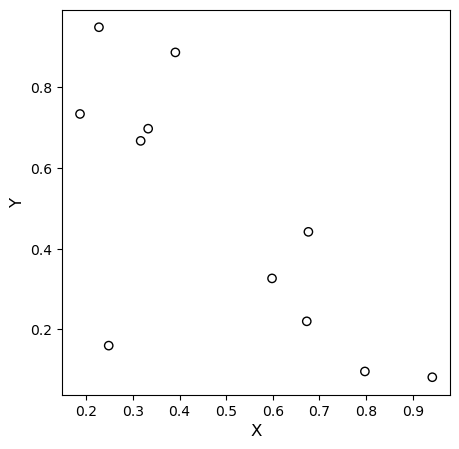

In [21]:
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

I'm going to say that I don't want to use a 10th order polynomial.  We've seen that, although it is mathematically possible, it overfits the data, capturing all of the "wiggles," but this means it can be very far off when we use the model to predict anything other than the data points we measured.

So, I'll propose a model.  Looking at the data, I'll suggest that a linear model will describe this fairly well.  I'll represent that model as:

$$y(x) = \alpha_1x^1 + \alpha_0x^0$$

In other words: I have two unknown coefficients in that model, and I want to find their values from the data I have available (11 points). Since I have 11 data points, and they are all scattered (simulating experimental noise), it is clear that no single line will pass through all of the data points.  What I want to find is the one straight line that minimizes the error between the model and the measurements.  There are many ways to approach this, but the most common one is least squares regression.  In that approach, we define a metric called the sum of square errors:

$$\textrm{SSE} = \sum_i (y_i - \hat{y}_i)^2$$

Here, $y_i$ is *ith* measured value of our observable, $y$, at condition $x_i$, and $\hat{y}_i$ is the model's predicted value of our observable $y$ at condition $x_i$.

We will use this tool a lot. Whether you realize it or not, least squares is embedded in a lot of the tools you use routinely.  The one you're most familiar with is Excel's trendline feature, but also the very nice LINEST function in Excel is an implementation of linear least squares.  The methods below are also pretty much identical to what `np.polyfit()` does under the hood. For now, we'll frame this as an extension of our matrix method for polynomial interpolation.  

Let's say I propose a linear model to describe the above 11 data points.  I'll write copy of that linear model for every $(x,y)$ pair in our data set...

\begin{align}
    y_1    &= \alpha_1x_1 + \alpha_0 \\
    y_2    &= \alpha_1x_2 + \alpha_0 \\
    y_3    &= \alpha_1x_3 + \alpha_0 \\
    y_4    &= \alpha_1x_4 + \alpha_0 \\
    y_5    &= \alpha_1x_5 + \alpha_0 \\
    y_6    &= \alpha_1x_6 + \alpha_0 \\
    y_7    &= \alpha_1x_7 + \alpha_0 \\
    y_8    &= \alpha_1x_8 + \alpha_0 \\
    y_9    &= \alpha_1x_9 + \alpha_0 \\
    y_{10} &= \alpha_1x_{10} + \alpha_0 \\
    y_{11} &= \alpha_1x_{11} + \alpha_0 \\
\end{align}

In that set of equations, I know all of the $(x,y)$ entries because we measured y at every corresponding x.  I do not know the values of the coefficients $\alpha_1$ and $\alpha_2$.  That's what I'm trying to solve.  But here, I have 11 equations, and 2 unknowns, so there is no unique solution that will solve this system of equations.  Instead, I'm going to minimize error.  This is still a linear system since the problem is linear in our unknowns (all of the exponents on the alpha values are 1).  As such, we can use linear algebra to estimate their "best" values.  We start by putting the above system in matrix form:

$$\begin{bmatrix} x_1^1 & x_1^0 \\ x_2^1 & x_2^0 \\ x_3^1 & x_3^0 \\ x_4^1 & x_4^0 \\ x_5^1 & x_5^0 \\ x_6^1 & x_6^0 \\ x_7^1 & x_7^0 \\ x_8^1 & x_8^0 \\ x_9^1 & x_9^0 \\ x_{10}^1 & x_{10}^0 \\ x_{11}^1 & x_{11}^0 \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \\ y_5 \\ y_6 \\ y_7 \\ y_8 \\ y_9 \\ y_{10} \\ y_{11} \\  \end{bmatrix}$$

Or, as usual:

$$XA = Y$$

We'll run into a problem when we try to solve this, though (see below)

In [32]:
Ya = ydata
# np.vander(xdata)
# np.round(np.vander(xdata), 2)
np.round(np.vander(xdata, 2), 2)
Xa = np.vander(xdata, 2) #This creates the X matrix shown above, truncating at 1st order
print(Xa)
print(Ya)

[[0.22733602 1.        ]
 [0.31675834 1.        ]
 [0.79736546 1.        ]
 [0.67625467 1.        ]
 [0.39110955 1.        ]
 [0.33281393 1.        ]
 [0.59830875 1.        ]
 [0.18673419 1.        ]
 [0.67275604 1.        ]
 [0.94180287 1.        ]
 [0.24824571 1.        ]]
[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ]


If we try to solve the matrix system with that X, though, we'll hit an error...

In [24]:
A = np.linalg.solve(Xa, Ya)

LinAlgError: Last 2 dimensions of the array must be square

This comes up because we can't invert a non-square matrix...(X is tall, not square)

In [25]:
np.linalg.inv(Xa)

LinAlgError: Last 2 dimensions of the array must be square

The linear algebra way to approach this problem follows.  We start with our non-square X matrix, and we apply the following multiplication steps.  Note that multiplying X by its transpose will create a square matrix, which we can invert.

\begin{align}
    XA &= Y \\
    X^TXA &= X^TY \\
    \left(X^TX\right)^{-1}X^TXA &= \left(X^TX\right)^{-1}X^TY \\
    IA &= \left(X^TX\right)^{-1}X^TY \\
    A &= \left(X^TX\right)^{-1}X^TY \\
\end{align}

Believe it or not, that operation on the right hand side, $\left(X^TX\right)^{-1}X^TY$ actually minimizes the sum of squares for this linear problem.  This is a completely general result, and we can use a matrix method to solve for the optimum coefficients (giving the line of "best fit") for any problem that is linear in its coefficients.  See below.

In [26]:
A = np.linalg.solve(Xa.T@Xa, Xa.T@Ya) 
#The above is equivalent to (but more memory efficient) than np.linalg.inv(X.T@X)@X.T@Y
print(A)

[-0.90421001  0.92118569]


Now we'll use those "optimum" coefficients to create the best fit straight line to our data set...

Note that since these are matrices, we can get our predicted Y values from the following relationship by matrix multiplication

$$\hat{Y} = X\hat{A}$$

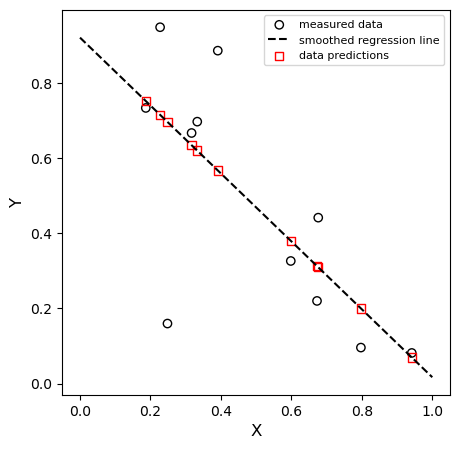

In [27]:
xline = np.linspace(0, 1, 100)
yline = lambda x: A[0]*x + A[1]

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xa@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

Is it perfect?  No.  But this is the line that best describes our data.  We might alternatively choose a different model (2nd order, exponential function, etc), but if we want a straight line to model that system, this is as good as it gets.

Note that this is exactly the result we'd get if we put xdata and ydata into Excel, plotted them, and added a trendline.  If you try it, I am confident you'll find that:

1. slope = -0.904
2. y-intercept = 0.921

Why?  Because we just went through what trendline does under the hood.  Now you know!!

You want a quadratic fit?  No problem!!

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 

[[0.05 0.23 1.  ]
 [0.1  0.32 1.  ]
 [0.64 0.8  1.  ]
 [0.46 0.68 1.  ]
 [0.15 0.39 1.  ]
 [0.11 0.33 1.  ]
 [0.36 0.6  1.  ]
 [0.03 0.19 1.  ]
 [0.45 0.67 1.  ]
 [0.89 0.94 1.  ]
 [0.06 0.25 1.  ]] 

[-0.69969354 -0.14991027  0.76170812]


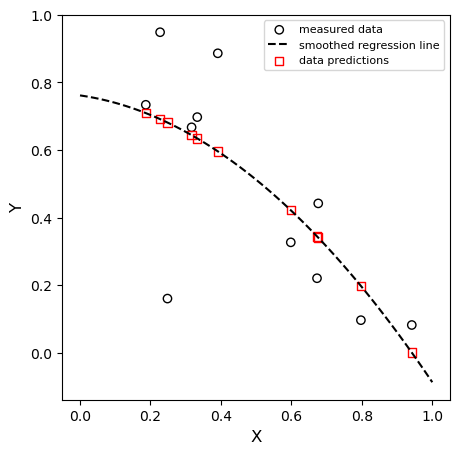

In [36]:
Yb = ydata
Xb = np.vander(xdata,3)
print(Yb, '\n')
print(np.round(Xb, 2), '\n')
A = np.linalg.solve(Xb.T@Xb, Xb.T@Yb) 
print(A)
yline = lambda x: A[0]*x**2 + A[1]*x + A[2]
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xb@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

Third order? Why not?

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 

[[0.01 0.05 0.23 1.  ]
 [0.03 0.1  0.32 1.  ]
 [0.51 0.64 0.8  1.  ]
 [0.31 0.46 0.68 1.  ]
 [0.06 0.15 0.39 1.  ]
 [0.04 0.11 0.33 1.  ]
 [0.21 0.36 0.6  1.  ]
 [0.01 0.03 0.19 1.  ]
 [0.3  0.45 0.67 1.  ]
 [0.84 0.89 0.94 1.  ]
 [0.02 0.06 0.25 1.  ]] 

[ 4.85887321 -9.04727267  4.12600401  0.14299066]


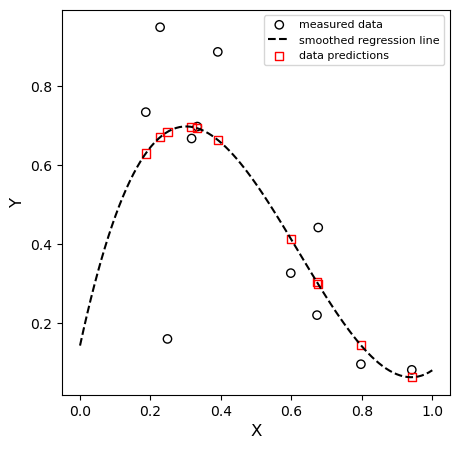

In [38]:
Yc = ydata
Xc = np.vander(xdata,4)
print(Yc, '\n')
print(np.round(Xc, 2), '\n')
A = np.linalg.solve(Xc.T@Xc, Xc.T@Yc) 
print(A)
yline = lambda x: A[0]*x**3 + A[1]*x**2 + A[2]*x + A[3]

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xc@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

And on it goes up to 10th order, where we have a unique solution.

## For Fall 2025: 

Consider stopping here.  The SSE and various other metrics start being useful around L30, and they would probably be retained better if introduced there instead of here.  Can truncate presentation to just focus on the coefficients and visually showing the line of best fit overlay.

### Extra, useful things to accompany regression

We calculate the residual sum of squares as usual:

$$SSE = \sum_i (y_i - \hat{y}_i)^2$$

Which, for a linear regression problem is equivalent to:

$$SSE = (Y - XA)^T(Y - XA)$$

In numpy that would be:

    SSE = (Y - X@A).T@(Y - X@A)

Mean Square Error is another useful metric. It quantifies the average square error in our data fit:

$$MSE = \frac{SSE}{n_m}$$

Where $n_m$ is the number of data points/measurements. From this, we can get the root mean square error, which is a good approximation of the absolute displacement (error) between our model and our measurement.

$$RMSE = \sqrt{MSE}$$

The total sum of squares quantifies the error between the measurement and the mean of measurments:

$$SST = \sum_i (y_i - \bar{y}_i)$$

If we have the residual and total sum of squares, we can calculate the coefficient of determination:

$$R^2 = 1 - \frac{SSE}{SST}$$

If you want to obtain estimates of standard error in the slope and y intercept that you regress, you need to estimate the covariance matrix.  First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With that, we can estimate the covariance matrix from the measured data:

$$COV = s^2(X^TX)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in the slope from `se[0,0]` and the standard error in the intercept from `se[1,1]`, i.e., the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

Finally, noting that I'm working with a linear system, if I want to generate predicted values of my measured quantity (here ln(CA)), I can do so by multiplying my truncated vandermonde matrix by the regressed coefficients:

$$\hat{Y} = X\hat{A}$$

m    = -0.90 +/- 0.65
b    = 0.92 +/- 0.65
SSE  = 0.49
SST  = 1.03
MSE  = 0.04
RMSE = 0.21
R2   = 0.52


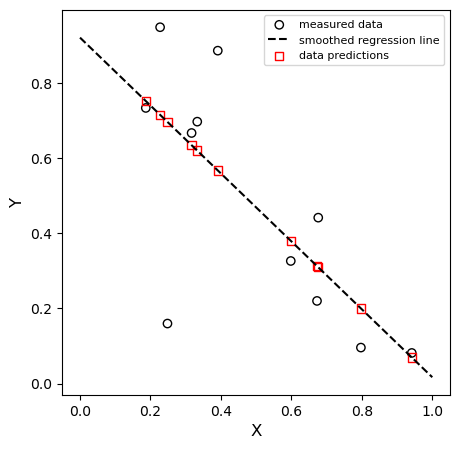

In [40]:
Ya     = ydata
Xa     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order
A      = np.linalg.solve(Xa.T@Xa, Xa.T@Ya) 
Ypred  = Xa@A
Ybar   = np.mean(ydata)
Ndata  = len(ydata)
SSE1   = np.sum((Ya - Ypred)**2)
SSE2   = (Ya - Xa@A).T@(Ya - Xa@A)
SST    = np.sum((Ya - Ybar)**2)
MSE    = SSE1/Ndata
RMSE   = np.sqrt(MSE)
R2     = 1 - SSE1/SST
DOF    = len(ydata) - len(A)
s2     = SSE1/DOF
COV    = s2*np.linalg.inv(Xa.T@Xa)
m      = A[0]
b      = A[1]
SEm    = np.sqrt(COV[0, 0])
SEb    = np.sqrt(COV[1, 1])
tval   = stats.t.ppf(0.975, DOF)
CIm    = SEm*tval
CIb    = SEb*tval
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE,  R2]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    else:
        print(f'{label:4s} = {value:0.2f}')

xline = np.linspace(0, 1, 100)
yline = lambda x: A[0]*x + A[1]
plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xa@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

## FYI, Python will do all this stuff for you if you want...

For your reference, Python will do most of this automatically through either np.polyfit or `np.linalg.leastsq()`

In [41]:
A1 = np.polyfit(xdata, ydata, 1) #Fit a first order polynomial to data, two coefficients
A2 = np.polyfit(xdata, ydata, 2) #Fit a second order polynomial to data, three coefficients
A3 = np.polyfit(xdata, ydata, 3) #Fit a third order polynomial to data, four coefficients
print(A1)
print(A2)
print(A3)

[-0.90421001  0.92118569]
[-0.69969354 -0.14991027  0.76170812]
[ 4.85887321 -9.04727267  4.12600401  0.14299066]


Numpy is very nice because it will both do the regression for us (using `np.polyfit()`), and it will generate a polynomial for us so that we can make predictions (using `np.polyval()`).  This is an automated version of what we did above using matrices.

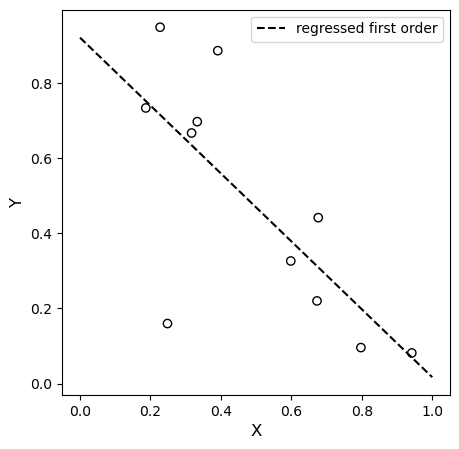

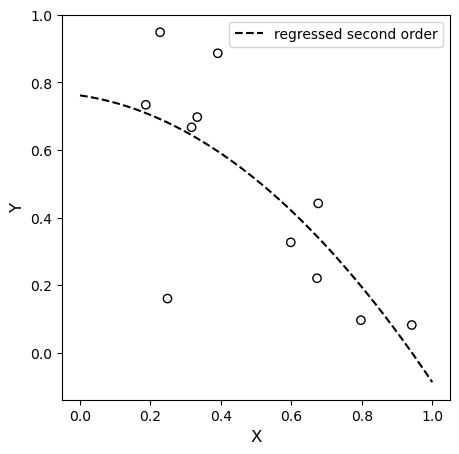

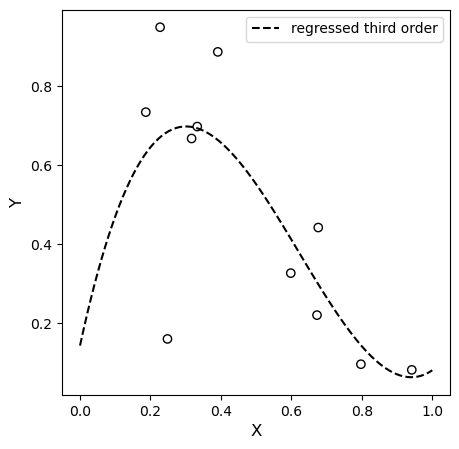

In [42]:
first  = np.polyval(A1, xline)
second = np.polyval(A2, xline)
third  = np.polyval(A3, xline)

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, first, color = 'black', linestyle = 'dashed', label = 'regressed first order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, second, color = 'black', linestyle = 'dashed', label = 'regressed second order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

plt.figure(3, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, third, color = 'black', linestyle = 'dashed', label = 'regressed third order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

Numpy also has the least squares version of `np.linalg.solve()`, which has a very similar syntax and will return least squares regressed coefficients same as above.  See results below for a first and second order regression of our the "tall" matrices above.  These will return regressed coefficients and the minimum sum of squares.

In [43]:
coeffs_1, SSE_1, cov_1, sing_1 = np.linalg.lstsq(Xa, Ya, rcond = None)
coeffs_2, SSE_2, cov_2, sing_2 = np.linalg.lstsq(Xb, Yb, rcond = None)
coeffs_3, SSE_3, cov_3, sing_3 = np.linalg.lstsq(Xc, Yc, rcond = None)
#np.linalg.lstsq(Xc, Yc, rcond = None)

print(coeffs_1, SSE_1)
print(coeffs_2, SSE_2)
print(coeffs_3, SSE_3)

[-0.90421001  0.92118569] [0.49163018]
[-0.69969354 -0.14991027  0.76170812] [0.47936939]
[ 4.85887321 -9.04727267  4.12600401  0.14299066] [0.45149249]
